# Read ice sheet contribution to sea level and fingerprints

In [25]:
#Load packages
import sys
sys.path.append('../code')

import matplotlib.pyplot as plt
import numpy as np
import gzip
import pandas as pd
#import cdms2
import cartopy.crs as ccrs
import netCDF4
import xarray as xr
import xesmf as xe

from ipywidgets import interact
import ipywidgets as widgets

import SeaLevelContrib as slc

#%matplotlib inline

In [85]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
# Define a few constants
er = 6.371e6 # Earth's radius in meters
oa = 3.6704e14 # Total ocean area m**2
rho_i = 917 # Ice density kg/m**3

In [3]:
kern_dir = '/Users/dewilebars/Projects/SLBudget/data/Mitrovica2018Kernels/'

#List the tide gauges of interest
tg_names = ['Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 
            'Harlingen', 'IJmuiden']
tg_names_c = [x.upper() for x in tg_names]

# Check if these tide gauges are available in sites.txt and read their numbers
tg_nb = []
for tg_n in tg_names_c:
    if tg_n not in open(kern_dir + 'sites.txt').read():
        print('This tide gauge is not available: ' + tg_n)
    else:
        for i, line in enumerate(open(kern_dir + 'sites.txt').readlines()):
            if tg_n in line:
                #y = line.strip()
                tg_nb.append(int(''.join(x for x in line if x.isdigit())))
tg_nb

[321, 351, 357, 363, 369, 396]

In [4]:
region = 'ant' # green, ant, alaska
ki=gzip.open(kern_dir + 'kernels/grid_396_'+ region +'.txt.gz','rb')
#file_content=f.read()
k1 = np.loadtxt(ki)
k1[k1 == 0] = np.nan
k1 = k1[::-1,:]
k1.shape[0]

256

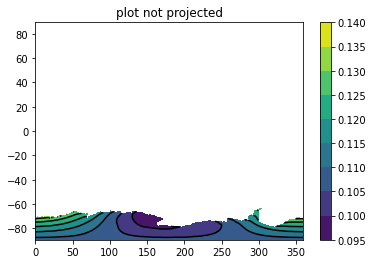

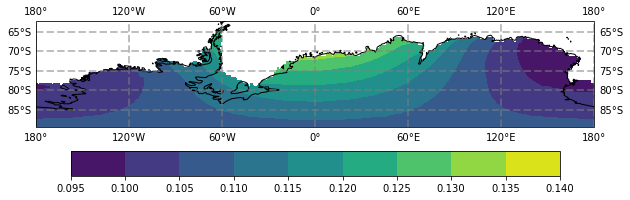

In [5]:
# Plot
# T0 use the cdms2 package use:
#lat1D = cdms2.createGaussianAxis(k1.shape[0])
#lat1D = lat1D[::-1]
gl = np.polynomial.legendre.leggauss(k1.shape[0])
lat1D = (np.arcsin(gl[0]) / np.pi) * 180
lon1D = np.linspace( 0, 360. - 360. / k1.shape[1], k1.shape[1])


def plotk(lat1D, lon1D, array_in):
    #proj = ccrs.PlateCarree() #Orthographic(central_longitude=-45.0, central_latitude=80.0, globe=None) 
                                # Orthographic, Mercator, PlateCarree, SouthPolarStereo
    
    if region == 'green':
        proj = ccrs.PlateCarree()
        fig = plt.figure(figsize=(8, 8))
        ax0 = fig.add_subplot(1, 1, 1, projection=proj)
        cs = ax0.contourf(lon1D, lat1D, array_in, transform=proj, cmap='RdBu')
        fig.colorbar(cs, ax=ax0, orientation='vertical')
        gl = ax0.gridlines(crs=proj, draw_labels=True,linewidth=2, color='gray', 
                           alpha=0.5, linestyle='--')
        ax0.set_extent((-80, 0, 50, 90), crs=None)
    elif region == 'ant':
        fig = plt.figure(figsize=(10, 3))
        #proj = ccrs.Orthographic(central_longitude=-45.0, central_latitude=80.0) #,globe=None
        proj = ccrs.PlateCarree()
        ax0 = fig.add_subplot(1, 1, 1, projection=proj)
        cs = ax0.contourf(lon1D, lat1D, array_in, transform=proj)
        fig.colorbar(cs, ax=ax0, orientation='horizontal')
        gl = ax0.gridlines(crs=proj, draw_labels=True,linewidth=2, color='gray', 
                           alpha=0.5, linestyle='--')

    #fig,ax0 = plt.subplots(1,figsize=(10,10),subplot_kws={'projection':proj})
    #ax0.set_title('plot test')
    #ax0.set_aspect('auto')
    ax0.set_aspect(2.5)
    #ax0.set_yticks(lat1D)
    #ax0.set_xticks(lon1D)

    ax0.coastlines()
    #fig.savefig('../figures/plot_Greenland_klimaatbericht.png', dpi=150)
    fig.savefig('../figures/plot_Antarctica_reverse_fingerprint_DutchCoast.png', dpi=150)
    #plt.show()

def plotnp(lat1D, lon1D, array_in):
    fig, ax0 = plt.subplots()
    cs = ax0.contourf(lon1D, lat1D, array_in)
    fig.colorbar(cs, ax=ax0)
    ax0.set_title('plot not projected')
    ax0.contour(cs, colors='k')
    
plotnp(lat1D, lon1D, k1)
plotk(lat1D, lon1D, k1)

The kernels from Mitrovica need to be combined with ice height change to obtain sea level change. This is given by equation (1) from Mitrovica et al. 2018:
$$ SL(r_0) = \iint_{\Omega} \rho_I I(\theta, \phi) K_0 (\theta, \phi) d\Omega $$
Which is simplified to:
$$ SL(r_0) = \iint_{\Omega} I(\theta, \phi) K_0^* (\theta, \phi) d\Omega_u $$
with:
$$ K_0^* (\theta, \phi) = \rho_I K_0 (\theta, \phi) a^2 $$
where $I$ is the change in ice height and $K_0^*$ is the data provided by Mitrovica et al. 2018. 


### Little computation for the klimaatbericht of December 2019.

To compare the local sea level effect to global sea level we scale $K_0$ by the global sea level rise effect $K_g$.

In [6]:
kg = 1e-3 / 360e12
k1s = k1 / (er**2 * rho_i * kg)

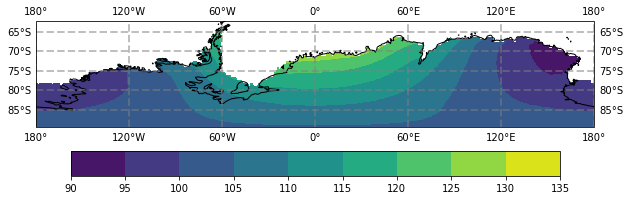

In [7]:
# Uncomment the line:
#fig.savefig('plot_Greenland_klimaatbericht.png', dpi=150)
# in plotk to create a figure.
plotk(lat1D, lon1D, k1s*100)

### Read GRACE data from Adhikari et al. 2019.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_256x512_360x720.nc 
Reuse pre-computed weights? False 
Input grid shape:           (256, 512) 
Output grid shape:          (360, 720) 
Periodic in longitude?      False
(360, 720)


/Users/dewilebars/anaconda3/envs/p39ds/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


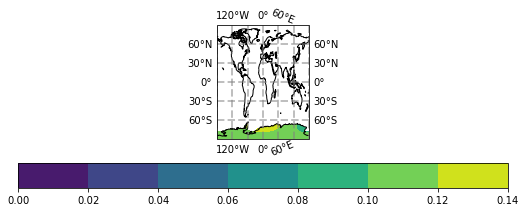

In [20]:
# The grid is uniform with 0.5º steps
Adh_dir = '/Users/dewilebars/Projects/SLBudget/data/Adhikari2019/'
#slf_ds = netCDF4.Dataset(Adh_dir + 'SLFgrids_GFZOP_CM_WITHrotation.nc')
slf_ds = xr.open_dataset(Adh_dir + 'SLFgrids_GFZOP_CM_WITHrotation.nc')
lat = slf_ds.variables['lat'][:]
lon = slf_ds.variables['lon'][:]

# Compute the area of each grid cell. The equivalent of Matlab function 
#areaquad or NCL area_poly_sphere would be useful here.
area = np.zeros(lat.shape[0])
area = er**2 * (np.sin(np.radians(lat + 0.25)) - np.sin(np.radians(lat - 0.25))) * np.radians(0.5)
area = xr.DataArray(area, dims=('lat'))

# Regrid kernels onto the Adhikari grid. The regridder command only needs to be done once. 
#The weights are then stored locally for further use. 
#Since the kernels do not have metadata, the coordinates need to be given separately.
grid_in = {'lon': lon1D, 'lat': lat1D}
regridder = xe.Regridder(grid_in, slf_ds, 'bilinear')
print(regridder)  # print basic regridder information

k1_rg = regridder(k1)  # regrid a basic numpy array
# The regridding introduces some 0s in the array, why is that?
k1_rg = xr.DataArray(k1_rg, dims=('lat','lon'))

print(k1_rg.shape)

plotk(lat, lon, k1_rg)

sea level rise at ?
<xarray.DataArray ()>
array(2.34156205)
sea level rise at ? assuming uniform melt distribution
<xarray.DataArray ()>
array(2.70750837)
Global sea level rise (mm)
<xarray.DataArray ()>
array(2.71120517)
Fraction for uniform assumption
<xarray.DataArray ()>
array(0.99863647)


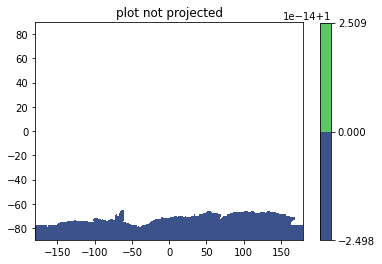

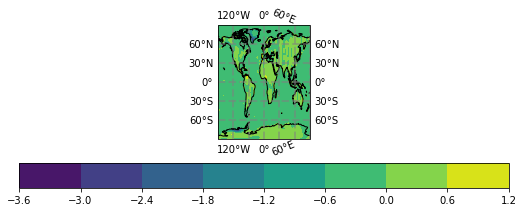

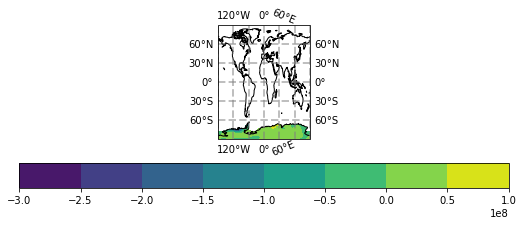

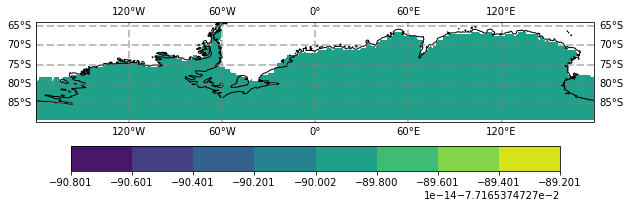

In [15]:
weh = slf_ds['weh']
# Height difference between the end and the beginning of the time series
weh_diff = weh[-1, :, :] -  weh[0, :, :]

# Compute the product of kernels and weh and plot time series of Greenland/Ant/Alaska 
slr_im = k1_rg*weh_diff*area
slr_im_ts = k1_rg*weh*area
k1_rg_1 = k1_rg.copy()
k1_rg_1 = xr.where(k1_rg == 0, np.nan, k1_rg_1)
k1_rg_1 = xr.where(np.isnan(k1_rg_1), k1_rg_1, 1)
slr_glo_im = k1_rg_1 * weh_diff * area

weh_diff_u = weh_diff*k1_rg_1 # Mask the region of interest
weh_diff_u_val = slr_glo_im.sum() / np.sum(k1_rg_1 * area)
weh_diff_u = xr.where(np.isnan(weh_diff_u), weh_diff_u, weh_diff_u_val)
slr_im_u = k1_rg*weh_diff_u*area # Uniform pattern of melt

# Effects for different tide gauges locations
slr_tg_diff = - slr_im.sum() * 1000 / er**2
print('sea level rise at ?' )
print(slr_tg_diff)
# Using a uniform melt distribution
slr_tg_u = - slr_im_u.sum() * 1000 / er**2
print('sea level rise at ? assuming uniform melt distribution')
print(slr_tg_u)

# Full time series
slr_tg_diff = - slr_im_ts.sum(dim='lat').sum(dim='lon') * 1000 / er**2
slr_tg_diff = slr_tg_diff - slr_tg_diff[0]
#print(slr_tg_diff)
# Global sea level rise
slr_glo = - slr_glo_im.sum() * 1000 / oa
print('Global sea level rise (mm)')
print(slr_glo)

print('Fraction for uniform assumption')
print(slr_tg_u/slr_glo)

# Check that it matches with rsl variable -> Only possible once all the sources of mass change are added

plotnp(lat, lon, k1_rg_1)
plotk(lat, lon, weh_diff)
plotk(lat, lon, slr_im)
plotk(lat, lon, weh_diff_u)

In [16]:
# Use the mass loss patterns for different sea level reconstructions: Compare global and local effects
# Which reconstructions? IMBIE
# How can it be compared with IPCC? Use the files from AR5 directly

In [21]:
# Showcase the use of the interact function from the ipython widgets to read
# data from Adhikari et al. 2019.
slf = netCDF4.Dataset(Adh_dir + 'SLFgrids_GFZOP_CM_WITHrotation.nc')
weh = slf.variables['weh']
lat = slf.variables['lat']
lon = slf.variables['lon']

def sh(var='weh', time=0):
    vv = slf.variables[var][:,:,:]
    vv[ vv == 0 ] = np.nan
    fig = plt.imshow(vv[time,::-1,:])
#    datacursor(fig)
    
vari = slf.variables.keys()
interact(sh, time=(0,132,1), var=vari);


interactive(children=(Dropdown(description='var', index=3, options=('lat', 'lon', 'time', 'weh', 'rsl', 'ghc',…

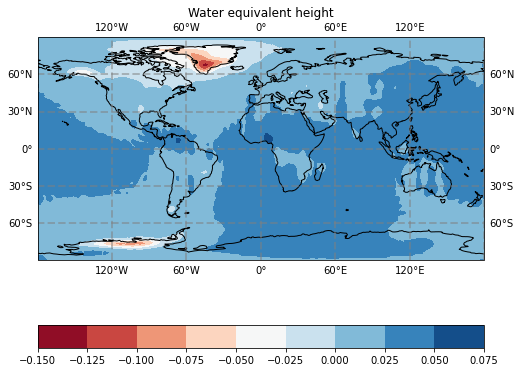

In [22]:
rsl = slf_ds.variables['rsl'][:, :, :]

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 8))
ax0 = fig.add_subplot(1, 1, 1, projection=proj)
cs = ax0.contourf(lon[:], lat[:], rsl[132, : , :] - rsl[0, : , :], transform=proj, cmap='RdBu')
fig.colorbar(cs, ax=ax0, orientation='horizontal')
ax0.set_title('Water equivalent height')
#ax0.set_aspect(2.5)
gl = ax0.gridlines(crs=proj, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#ax0.set_global()
#ax0.set_extent((-80, 0, 50, 90), crs=None) #lons lone lats late
ax0.coastlines()

In [27]:
def psmsl2mit(tg_id):
    '''Function that translates the tide gauge number from the PSMSL data base to 
    the numbers used by the kernels of Mitrovica et al. 2018'''
    tg_data_dir = '/Users/dewi/Work/Project_SeaLevelBudgets/rlr_annual'
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')
    filelist_df['name'] = filelist_df['name'].str.strip() #Remove white spaces in the column
    print(len(filelist_df))
    tg_id_mit = []
    for i in tg_id:
        tg_n = filelist_df['name'][i].upper()
        if tg_n not in open(kern_dir + 'sites.txt').read():
            print('This tide gauge is not available: ' + tg_n)
        else:
            for j, line in enumerate(open(kern_dir + 'sites.txt').readlines()):
                if tg_n in line:
                    tg_id_mit.append(int(''.join(x for x in line if x.isdigit())))
    return tg_id_mit

def tg_lat_lon(tg_id):
    '''Give tide gauge latitude, longitude location given the id as input'''
    tg_data_dir = '/Users/dewi/Work/Project_SeaLevelBudgets/rlr_annual'
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')
    return filelist_df.loc[tg_id].lat, filelist_df.loc[tg_id].lon

#Fingerprint function

tg_id = [20, 22]
mitu = slc.ices_fp(tg_id, 'mit_unif', 'green') #'ant' or 'green'

print(mitu)

0.15818601329562632


### Compute the fingerprints from the budget of Frederikse et al. 2020

In [64]:
tg_id = [23] # 23: Den Helder

glaciers = slc.contrib_frederikse2020_glob('Glaciers')
gis = slc.contrib_frederikse2020_glob('Greenland Ice Sheet')
ais = slc.contrib_frederikse2020_glob('Antarctic Ice Sheet')

glaciers_loc = slc.contrib_frederikse2020(tg_id, 'glac')
gis_loc = slc.contrib_frederikse2020(tg_id, 'GrIS')
ais_loc = slc.contrib_frederikse2020(tg_id, 'AIS')

df = glaciers.join([gis, ais, glaciers_loc, gis_loc, ais_loc])
df.columns = ['glaciers', 'gis', 'ais', 'glaciers_loc', 'gis_loc', 'ais_loc']

df = df -df.iloc[0]

df['glaciers_fp'] = df['glaciers_loc']/df['glaciers']
df['gis_fp'] = df['gis_loc']/df['gis']
df['ais_fp'] = df['ais_loc']/df['ais']

In [65]:
df

,glaciers,gis,ais,glaciers_loc,gis_loc,ais_loc,glaciers_fp,gis_fp,ais_fp
time,,,,,,,,,
1900,0.000000,0.000000,0.000000,0.000,0.000,0.000,NaN,NaN,NaN
1901,0.084988,-0.011496,0.005453,0.075,-0.005,0.005,0.882471,0.434935,0.916966
1902,0.171006,0.020273,0.010925,0.145,0.000,0.010,0.847923,0.000000,0.915354
1903,0.228160,0.061088,0.016302,0.195,0.005,0.015,0.854664,0.081849,0.920115
1904,0.312296,0.143787,0.021722,0.245,0.010,0.020,0.784513,0.069547,0.920735
...,...,...,...,...,...,...,...,...,...
2014,8.216150,5.191397,1.126490,5.640,0.460,1.015,0.686453,0.088608,0.901029
2015,8.294636,5.249441,1.219641,5.715,0.475,1.110,0.689000,0.090486,0.910104
2016,8.365172,5.324618,1.200678,5.770,0.485,1.085,0.689765,0.091086,0.903656


<AxesSubplot:xlabel='time'>

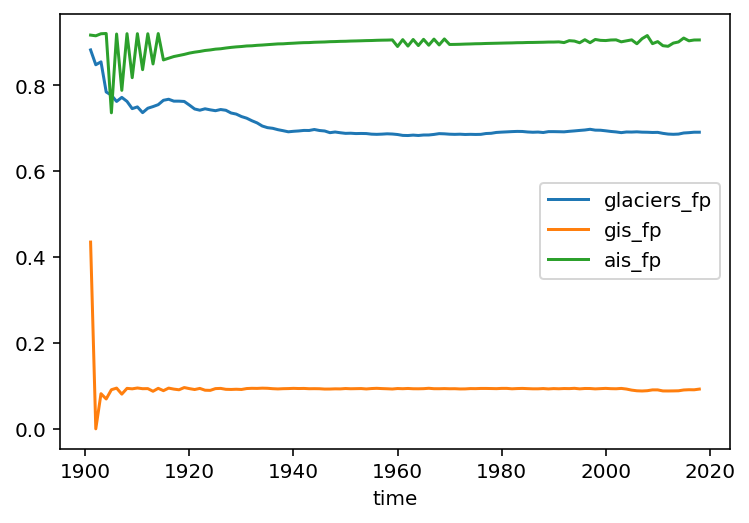

In [86]:
df[['glaciers_fp', 'gis_fp', 'ais_fp']].plot()

<AxesSubplot:xlabel='time'>

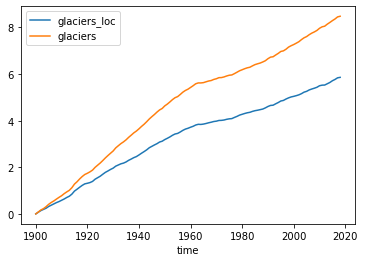

In [67]:
df[['glaciers_loc','glaciers']].plot()

In [78]:
# Compute the fingerprints for a specific period
years = {'p1s': 1986, 'p1e': 2005, 'p2s': 2006, 'p2e': 2018}

def fp_period(years, df, var):
    loc_diff = df[f'{var}_loc'].loc[p2s:p2e].mean() - df[f'{var}_loc'].loc[p1s:p1e].mean()
    glo_diff = df[f'{var}'].loc[p2s:p2e].mean() - df[f'{var}'].loc[p1s:p1e].mean()
    glaciers_fp = loc_diff/glo_diff
    
    return glaciers_fp

#gis_fp = df['gis_loc'].loc[p1s:p1e].mean()/df['gis']
#ais_fp = df['ais_loc'].loc[p1s:p1e].mean()/df['ais']

In [81]:
gla_fp_p = fp_period(years, df, 'glaciers')
gla_fp_p

0.6667542941042002

In [82]:
ais_fp_p = fp_period(years, df, 'ais')
ais_fp_p

0.901736729924021

In [83]:
gis_fp_p = fp_period(years, df, 'gis')
gis_fp_p

0.07398568216887484

### Compare with AR5 fingerprints